<a href="https://colab.research.google.com/github/rcollmenendez/propulsion_challenges/blob/main/Advanced_Classification_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting how likely is a pirate attack to be successful

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine Learning classes from sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer, KNNImputer

# Load models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Pirates dataset

### Dataset Description:

You, the High Commander of the 7 Seas, are tasked to predict whether a Pirate attack is likely to be successful. It just so happens that you are also a talented Data scientist! You are provided with a dataset on vessels that have been attacked by pirates. Your dataset describes the attributes of a successful (1) and an unsuccessful (0) attack. The columns are described as follow:

DATETIME (LOCAL): The local date and time of when the attack occurred

DATETIME (UTC): The date and time in UTC format of when the attack occurred

DATE (LT): The date in local time of when the attack occurred

DATE (UTC): The date in UTC format of when the attack occurred

REGION: Region in which the attack took place

COUNTRY: Country of the occurrence

INCIDENT TYPE: Type of the attack

MAERSK: Indicates whether the attacked vessel belonged to the MAERSK shipping company

VESSEL ACTIVITY LOCATION: Location of the vessel during attack

LAT: Latitude coordinate of attack

LONG: Longitude coordinate of attack

TIMEZONE: Time zone in which the attack occurred

TIME OF DAY: General time of day when the attack occurred

ATTACKS: Indicate whether the attack occurred (1: attack occurred, 0: attack did not occur)

ATTACK SUCCESS: Indicate whether the attack was successful or not.

In [39]:
# Load pirate_data.csv
df = pd.read_csv("/content/drive/MyDrive/0_data/04_MachineLearning/pirate_data.csv", index_col=0)
df.head(4)

,DATETIME (LOCAL),DATETIME (UTC),DATE (LT),DATE (UTC),REGION,COUNTRY,INCIDENT TYPE,VESSEL TYPE,MAERSK?,VESSEL ACTIVITY LOCATION,LAT,LONG,TIMEZONE,TIME OF DAY,ATTACKS,ATTACK SUCCESS
1,2016-01-30 23:34:00,2016-01-30 22:34:00,2016-01-30,2016-01-30,WEST AFRICA,NIGERIA,"FAILED ATTACK, HIJACKING",CONTAINER SHIP,0,OFF SHORE,3.000000,6.250000,Africa/Lagos,EVENING,1,0
2,2016-01-29 23:40:00,2016-01-29 22:40:00,2016-01-29,2016-01-29,WEST AFRICA,NIGERIA,KIDNAP/RANSOM AT SEA,PRODUCT TANKER,0,OFF SHORE,2.500000,5.750000,Africa/Lagos,EVENING,1,1
3,2016-01-28 03:00:00,2016-01-28 02:00:00,2016-01-28,2016-01-28,SOUTH ASIA,INDIA,"FAILED ATTACK, ROBBERY",PRODUCT TANKER,0,ANCHORAGE,22.816667,70.116667,Asia/Kolkata,NIGHT,1,0
4,NaN,NaN,2016-01-27,2016-01-27,HORN OF AFRICA/ GULF OF ADEN,SOMALIA,SUSPICIOUS ACTIVITY AT SEA,NaN,0,OFF SHORE,13.998747,54.112792,Asia/Riyadh,UNKNOWN,1,0


In [40]:
# Check columns, data types and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 802 entries, 1 to 802
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DATETIME (LOCAL)          582 non-null    object 
 1   DATETIME (UTC)            582 non-null    object 
 2   DATE (LT)                 802 non-null    object 
 3   DATE (UTC)                802 non-null    object 
 4   REGION                    802 non-null    object 
 5   COUNTRY                   802 non-null    object 
 6   INCIDENT TYPE             802 non-null    object 
 7   VESSEL TYPE               638 non-null    object 
 8   MAERSK?                   802 non-null    int64  
 9   VESSEL ACTIVITY LOCATION  676 non-null    object 
 10  LAT                       802 non-null    float64
 11  LONG                      802 non-null    float64
 12  TIMEZONE                  802 non-null    object 
 13  TIME OF DAY               802 non-null    object 
 14  ATTACKS   

In [41]:
# Change data types
df["DATETIME (LOCAL)"] = pd.to_datetime(df["DATETIME (LOCAL)"])
df["DATETIME (UTC)"] = pd.to_datetime(df["DATETIME (UTC)"])
df["DATE (LT)"] = pd.to_datetime(df["DATE (LT)"])
df["DATE (UTC)"] = pd.to_datetime(df["DATE (UTC)"])

In [42]:
# Extract some new fields from the dates
# Month and day from "DATE LT" that does not have nulls
df['MONTH'] = pd.DatetimeIndex(df["DATE (LT)"]).month_name()
df['DAY'] = pd.DatetimeIndex(df["DATE (LT)"]).day_name()

# Hour of the day in 24h format from "DATETIME (LOCAL)"
df['HOUR'] = pd.DatetimeIndex(df["DATETIME (LOCAL)"]).hour
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 802 entries, 1 to 802
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATETIME (LOCAL)          582 non-null    datetime64[ns]
 1   DATETIME (UTC)            582 non-null    datetime64[ns]
 2   DATE (LT)                 802 non-null    datetime64[ns]
 3   DATE (UTC)                802 non-null    datetime64[ns]
 4   REGION                    802 non-null    object        
 5   COUNTRY                   802 non-null    object        
 6   INCIDENT TYPE             802 non-null    object        
 7   VESSEL TYPE               638 non-null    object        
 8   MAERSK?                   802 non-null    int64         
 9   VESSEL ACTIVITY LOCATION  676 non-null    object        
 10  LAT                       802 non-null    float64       
 11  LONG                      802 non-null    float64       
 12  TIMEZONE              

In [43]:
# % of nulls per field
round(df.isnull().sum()/len(df) * 100, 1)

DATETIME (LOCAL)            27.4
DATETIME (UTC)              27.4
DATE (LT)                    0.0
DATE (UTC)                   0.0
REGION                       0.0
COUNTRY                      0.0
INCIDENT TYPE                0.0
VESSEL TYPE                 20.4
MAERSK?                      0.0
VESSEL ACTIVITY LOCATION    15.7
LAT                          0.0
LONG                         0.0
TIMEZONE                     0.0
TIME OF DAY                  0.0
ATTACKS                      0.0
ATTACK SUCCESS               0.0
MONTH                        0.0
DAY                          0.0
HOUR                        27.4
dtype: float64

### Check categorical variables

In [44]:
# Check diff values for categorical variables
for col_name in df.select_dtypes("object").columns.to_list():
  print("\n", col_name)
  print(df[col_name].unique())


 REGION
['WEST AFRICA' 'SOUTH ASIA' 'HORN OF AFRICA/ GULF OF ADEN' 'SOUTH AMERICA'
 'MIDDLE EAST' 'SOUTH EAST ASIA' 'NORTH AFRICA' 'NORTH EAST ASIA'
 'EAST AFRICA' 'EUROPE' 'PACIFIC' 'CARIBBEAN' 'NORTH AMERICA']

 COUNTRY
['NIGERIA' 'INDIA' 'SOMALIA' 'VENEZUELA' 'CONGO' "COTE D'IVOIRE" 'YEMEN'
 'INDONESIA' 'IRAN' 'LIBYA' 'SINGAPORE' 'EGYPT' 'VIETNAM' 'MALAYSIA'
 'CHINA' 'EQUATORIAL GUINEA' 'BANGLADESH' 'PHILIPPINES' 'TOGO' 'GHANA'
 'GUYANA' 'PERU' 'BENIN' 'ARGENTINA' 'KENYA' 'COLOMBIA' 'CAMEROON'
 'AUSTRALIA' 'DJIBOUTI' 'TURKEY' 'THAILAND' 'NEW ZEALAND' 'HAITI' 'USA'
 'GUINEA' 'TRINIDAD AND TOBAGO' 'FINLAND' 'TANZANIA' 'OMAN' 'SOUTH KOREA'
 'LIBERIA' 'SOUTH AFRICA' 'BAHRAIN' 'ANGOLA' 'MOZAMBIQUE' 'UKRAINE'
 'PANAMA' 'BRAZIL' 'SENEGAL' 'GUINEA-BISSAU' 'SIERRA LEONE'
 'PAPUA NEW GUINEA' 'HONDURAS' 'IRAQ' 'BAHAMAS']

 INCIDENT TYPE
['FAILED ATTACK, HIJACKING' 'KIDNAP/RANSOM AT SEA'
 'FAILED ATTACK, ROBBERY' 'SUSPICIOUS ACTIVITY AT SEA'
 'THEFT AT ANCHORAGE' 'ARMED ROBBERY AT SEA' 'FAILED

In [45]:
# Fill "UNKNOWN" with na
# df.loc[df["TIME OF DAY"] == "UNKNOW", "TIME OF DAY"] = np.nan
# df.loc[df["VESSEL TYPE"] == "UNKNOW", "VESSEL TYPE"] = np.nan

In [46]:
df.isna().sum()

DATETIME (LOCAL)            220
DATETIME (UTC)              220
DATE (LT)                     0
DATE (UTC)                    0
REGION                        0
COUNTRY                       0
INCIDENT TYPE                 0
VESSEL TYPE                 164
MAERSK?                       0
VESSEL ACTIVITY LOCATION    126
LAT                           0
LONG                          0
TIMEZONE                      0
TIME OF DAY                   0
ATTACKS                       0
ATTACK SUCCESS                0
MONTH                         0
DAY                           0
HOUR                        220
dtype: int64

### Check frequencies for each value of each categorical variable

In [47]:
# Region
df["REGION"].value_counts()

SOUTH EAST ASIA                 313
WEST AFRICA                     288
SOUTH ASIA                       67
HORN OF AFRICA/ GULF OF ADEN     34
MIDDLE EAST                      25
SOUTH AMERICA                    23
NORTH AFRICA                     18
NORTH EAST ASIA                  10
EAST AFRICA                       8
CARIBBEAN                         7
EUROPE                            5
PACIFIC                           3
NORTH AMERICA                     1
Name: REGION, dtype: int64

Let's group the regions with less than 10 observations

In [48]:
regions = df["REGION"].value_counts()[df["REGION"].value_counts() <= 10].index.to_list()
df.loc[df["REGION"].isin(regions), "REGION"] = "OTHER"
df["REGION"].value_counts()

SOUTH EAST ASIA                 313
WEST AFRICA                     288
SOUTH ASIA                       67
OTHER                            34
HORN OF AFRICA/ GULF OF ADEN     34
MIDDLE EAST                      25
SOUTH AMERICA                    23
NORTH AFRICA                     18
Name: REGION, dtype: int64

In [49]:
# Country
df["COUNTRY"].value_counts()

NIGERIA                209
INDONESIA              151
SINGAPORE               53
MALAYSIA                47
BANGLADESH              38
VIETNAM                 36
INDIA                   30
PHILIPPINES             21
SOMALIA                 19
LIBYA                   19
CONGO                   17
YEMEN                   16
GHANA                   15
COTE D'IVOIRE           13
COLOMBIA                11
CHINA                   11
TOGO                     8
DJIBOUTI                 6
GUINEA                   5
KENYA                    5
EGYPT                    5
VENEZUELA                4
IRAN                     4
PERU                     4
CAMEROON                 4
SIERRA LEONE             3
OMAN                     3
UKRAINE                  3
ANGOLA                   3
TURKEY                   3
TRINIDAD AND TOBAGO      3
BENIN                    3
LIBERIA                  3
BRAZIL                   2
GUINEA-BISSAU            2
PAPUA NEW GUINEA         2
SOUTH AFRICA             2
T

Let's group the countries with less than 10 cases in "others"

In [50]:
countries = df["COUNTRY"].value_counts()[df["COUNTRY"].value_counts() <= 9].index.to_list()
df.loc[df["COUNTRY"].isin(countries), "COUNTRY"] = "OTHER"
df["COUNTRY"].value_counts()

NIGERIA          209
INDONESIA        151
OTHER             96
SINGAPORE         53
MALAYSIA          47
BANGLADESH        38
VIETNAM           36
INDIA             30
PHILIPPINES       21
SOMALIA           19
LIBYA             19
CONGO             17
YEMEN             16
GHANA             15
COTE D'IVOIRE     13
CHINA             11
COLOMBIA          11
Name: COUNTRY, dtype: int64

In [51]:
# Vessel type
df["VESSEL TYPE"].value_counts()

BULK CARRIER                          134
PRODUCT TANKER                        107
CONTAINER SHIP                         60
TANKER                                 34
TUG                                    34
FISHING VESSEL                         33
MERCHANT VESSEL                        30
CRUDE OIL TANKER                       28
GENERAL CARGO VESSEL                   28
SUPPLY VESSEL                          25
PASSENGER VESSEL                       25
CHEMICAL TANKER                        15
LPG TANKER                             10
UNKNOWN                                10
VEHICLE CARRIER                         7
TRAWLER                                 7
BARGE                                   5
DREDGER                                 4
FISHING TRAWLER                         4
REEFER                                  3
HEAVY LIFT VESSEL                       3
SECURITY VESSEL                         2
RESEARCH VESSEL                         2
FISHING DHOW                      

In [52]:
vessel_types = df["VESSEL TYPE"].value_counts()[df["VESSEL TYPE"].value_counts() <= 6].index.to_list()
df.loc[df["VESSEL TYPE"].isin(vessel_types), "VESSEL TYPE"] = "OTHER"
df["VESSEL TYPE"].value_counts()

BULK CARRIER            134
PRODUCT TANKER          107
CONTAINER SHIP           60
OTHER                    51
TANKER                   34
TUG                      34
FISHING VESSEL           33
MERCHANT VESSEL          30
GENERAL CARGO VESSEL     28
CRUDE OIL TANKER         28
PASSENGER VESSEL         25
SUPPLY VESSEL            25
CHEMICAL TANKER          15
UNKNOWN                  10
LPG TANKER               10
VEHICLE CARRIER           7
TRAWLER                   7
Name: VESSEL TYPE, dtype: int64

Remove categorical variables that will not be used in the analysis

In [53]:
df = df.drop(columns=["DATETIME (LOCAL)", "DATETIME (UTC)", "DATE (LT)", "DATE (UTC)", "INCIDENT TYPE", "TIMEZONE", "MAERSK?"])

In [54]:
df.head(5)

,REGION,COUNTRY,VESSEL TYPE,VESSEL ACTIVITY LOCATION,LAT,LONG,TIME OF DAY,ATTACKS,ATTACK SUCCESS,MONTH,DAY,HOUR
1,WEST AFRICA,NIGERIA,CONTAINER SHIP,OFF SHORE,3.000000,6.250000,EVENING,1,0,January,Saturday,23.0
2,WEST AFRICA,NIGERIA,PRODUCT TANKER,OFF SHORE,2.500000,5.750000,EVENING,1,1,January,Friday,23.0
3,SOUTH ASIA,INDIA,PRODUCT TANKER,ANCHORAGE,22.816667,70.116667,NIGHT,1,0,January,Thursday,3.0
4,HORN OF AFRICA/ GULF OF ADEN,SOMALIA,NaN,OFF SHORE,13.998747,54.112792,UNKNOWN,1,0,January,Wednesday,NaN
5,SOUTH AMERICA,OTHER,GENERAL CARGO VESSEL,ANCHORAGE,10.267500,-63.432500,EVENING,1,1,January,Monday,23.0


### Check numerical variables

In [55]:
df["ATTACKS"].unique()

array([1])

In [56]:
# Feature selection
df = df.drop(columns=["ATTACKS"])
df.head(5)

,REGION,COUNTRY,VESSEL TYPE,VESSEL ACTIVITY LOCATION,LAT,LONG,TIME OF DAY,ATTACK SUCCESS,MONTH,DAY,HOUR
1,WEST AFRICA,NIGERIA,CONTAINER SHIP,OFF SHORE,3.000000,6.250000,EVENING,0,January,Saturday,23.0
2,WEST AFRICA,NIGERIA,PRODUCT TANKER,OFF SHORE,2.500000,5.750000,EVENING,1,January,Friday,23.0
3,SOUTH ASIA,INDIA,PRODUCT TANKER,ANCHORAGE,22.816667,70.116667,NIGHT,0,January,Thursday,3.0
4,HORN OF AFRICA/ GULF OF ADEN,SOMALIA,NaN,OFF SHORE,13.998747,54.112792,UNKNOWN,0,January,Wednesday,NaN
5,SOUTH AMERICA,OTHER,GENERAL CARGO VESSEL,ANCHORAGE,10.267500,-63.432500,EVENING,1,January,Monday,23.0


In [57]:
df.dtypes

REGION                       object
COUNTRY                      object
VESSEL TYPE                  object
VESSEL ACTIVITY LOCATION     object
LAT                         float64
LONG                        float64
TIME OF DAY                  object
ATTACK SUCCESS                int64
MONTH                        object
DAY                          object
HOUR                        float64
dtype: object

In [58]:
df["HOUR"] = df["HOUR"].astype(str)

In [59]:
# df = df.dropna().reset_index(drop=True)
# df.info()

### Check class imbalance 

In [60]:
df["ATTACK SUCCESS"].value_counts()

1    500
0    302
Name: ATTACK SUCCESS, dtype: int64

# Data preparation

In [61]:
X = df.drop(columns="ATTACK SUCCESS")
y = df["ATTACK SUCCESS"]

In [62]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((561, 10), (241, 10), (561,), (241,))

In [63]:
# Split the X_train data
categorical_features = X_train.select_dtypes("object").columns.to_list()
numeric_features = X_train.select_dtypes(["int64", "float64"]).columns.to_list()

print("Num of categorical features:", len(categorical_features))
print("Num of categorical features:", len(numeric_features))

Num of categorical features: 8
Num of categorical features: 2


In [64]:
# Create transformations
categorical_transformer = Pipeline(steps=[
                                          ("cat_imputer", SimpleImputer(strategy='constant',
                                                                        fill_value='UNKNOWN')),
                                          ("onehot", OneHotEncoder(handle_unknown="ignore"))
                                          ])

numeric_transformer = Pipeline(steps=[
                                      ("knn_imputer", KNNImputer(n_neighbors=5)),
                                      ("scaler", StandardScaler())
                                      ])

preprocessor = ColumnTransformer(transformers=[
                                               ("num", numeric_transformer, 
                                                       numeric_features),
                                               ("cat", categorical_transformer, 
                                                       categorical_features)
                                               ])

In [65]:
# Define models to test
lr = LogisticRegression(random_state=42, solver='liblinear')
knn = KNeighborsClassifier()
nb = BernoulliNB()
svc = LinearSVC(random_state=42, max_iter=5000)
dtree = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
ada_boost = AdaBoostClassifier(random_state=42)
gbm = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

# Support objects
models = {"LogisticRegression": lr,
          "KNNeighbors": knn,
          "BernoulliNB": nb,
          "LinearSVC": svc,
          "DecisionTree": dtree,
          "RandomForest": rf,
          "AdaBoost": ada_boost,
          "GradientBoosting": gbm,
          "XGB": xgb,
          }

scores_dict = {}
cross_val_dict = {}

In [66]:
# Define a function to calcualte the scores
def calc_score(preprocessor, model):
  
  pipeline = Pipeline(steps=[
                             ("pre_process", preprocessor), 
                             ("model", model)
                             ])
  
  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)

  train_score = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=4)
  train_score = round(np.mean(train_score), 3)

  test_score = round(f1_score(y_test, y_pred, average='weighted'), 3)

  return train_score, test_score

In [67]:
# Calculate the f1 score for each model
for model_name, model in models.items():
  
  train_score, test_score = calc_score(preprocessor, model)
  
  scores_dict[model_name] = [train_score, test_score]

In [68]:
# Create a dataframe with the scores
scores_df = pd.DataFrame.from_dict(scores_dict, orient='index', columns=["train - f1_score", "test - f1_score"])
scores_df

,train - f1_score,test - f1_score
LogisticRegression,0.702,0.661
KNNeighbors,0.710,0.643
BernoulliNB,0.671,0.668
LinearSVC,0.689,0.686
DecisionTree,0.655,0.575
RandomForest,0.724,0.641
AdaBoost,0.715,0.631
GradientBoosting,0.719,0.662
XGB,0.720,0.624


''

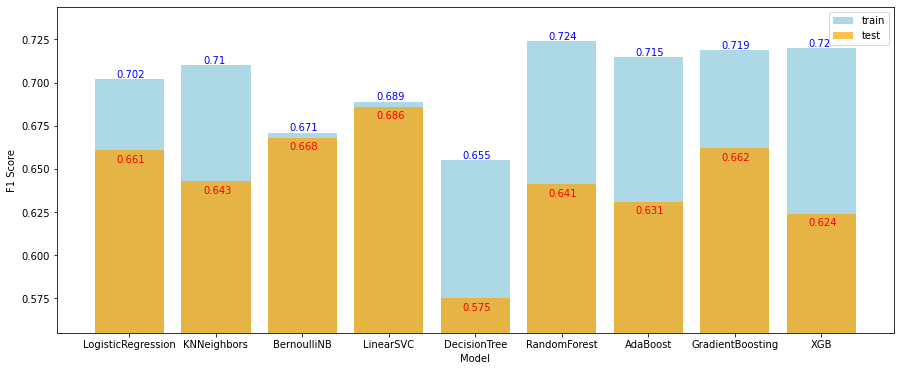

In [69]:
# Plot the scores
fig, ax = plt.subplots(figsize=(15,6))

ax.bar(scores_df.index, scores_df["train - f1_score"], label="train", color="lightblue")
ax.bar(scores_df.index, scores_df["test - f1_score"], label="test", color="orange", alpha=0.7)

# Plot text for train
x = scores_df.index
y = scores_df["train - f1_score"]
for i in range(len(x)):
        ax.text(i - 0.15, y[i]+0.001, y[i], color="blue")

# Plot text for test
x = scores_df.index
y = scores_df["test - f1_score"]
for i in range(len(x)):
        ax.text(i - 0.15, y[i]-0.007, y[i], color="red")

ax.set_ylim(min(scores_df["test - f1_score"])-0.02, max(scores_df["train - f1_score"])+0.02)
ax.set_xlabel("Model")
ax.set_ylabel("F1 Score")
ax.legend()
;

# Let's tune the KNN

In [74]:
knn_scores = {}

for n in range(2,15):
  knn = KNeighborsClassifier(n_neighbors=n)
    
  pipeline_knn = Pipeline(steps=[
                              ("pre_process", preprocessor), 
                              ("model", knn)
                              ])
    
  pipeline_knn.fit(X_train, y_train)

  y_pred = pipeline_knn.predict(X_test)

  train_score = cross_val_score(pipeline_knn, X_train, y_train, scoring='f1', cv=5)
  train_score = round(np.mean(train_score), 3)

  test_score = round(f1_score(y_test, y_pred, average='weighted'), 3)

  knn_scores[n] = [test_score, train_score]

In [ ]:
knn_df = pd.DataFrame.from_dict(knn_scores, orient='index', columns=["test_score", "train_score"])
knn_df

''

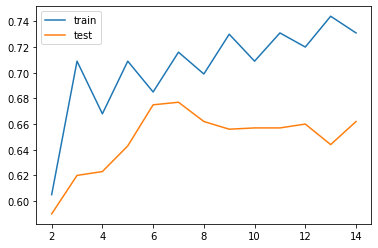

In [82]:
fig, ax = plt.subplots()

ax.plot(knn_df.index, knn_df["train_score"], label="train")
ax.plot(knn_df.index, knn_df["test_score"], label="test")
ax.legend()
;

Looks like we get the best performance in the cross validation with n=6 (balance between f1_score for the training dataset and overfitting)

# Testing XGB

In [34]:
xgb_model = XGBClassifier(random_state=42)
  
pipeline_xgb = Pipeline(steps=[
                             ("pre_process", preprocessor), 
                             ("model", xgb_model)
                             ])
  
pipeline_xgb.fit(X_train, y_train)

y_pred = pipeline_xgb.predict(X_test)

In [35]:
num_features = list(pipeline_xgb['pre_process'].transformers_[0][2])
cat_features = list(pipeline_xgb['pre_process'].transformers_[1][1]['onehot'].get_feature_names(categorical_features))
feature_cols = num_features + cat_features
num_features, cat_features

(['LAT', 'LONG'],
 ['REGION_HORN OF AFRICA/ GULF OF ADEN',
  'REGION_MIDDLE EAST',
  'REGION_NORTH AFRICA',
  'REGION_OTHER',
  'REGION_SOUTH AMERICA',
  'REGION_SOUTH ASIA',
  'REGION_SOUTH EAST ASIA',
  'REGION_WEST AFRICA',
  'COUNTRY_BANGLADESH',
  'COUNTRY_CHINA',
  'COUNTRY_COLOMBIA',
  'COUNTRY_CONGO',
  "COUNTRY_COTE D'IVOIRE",
  'COUNTRY_GHANA',
  'COUNTRY_INDIA',
  'COUNTRY_INDONESIA',
  'COUNTRY_LIBYA',
  'COUNTRY_MALAYSIA',
  'COUNTRY_NIGERIA',
  'COUNTRY_OTHER',
  'COUNTRY_PHILIPPINES',
  'COUNTRY_SINGAPORE',
  'COUNTRY_SOMALIA',
  'COUNTRY_VIETNAM',
  'COUNTRY_YEMEN',
  'VESSEL TYPE_BULK CARRIER',
  'VESSEL TYPE_CHEMICAL TANKER',
  'VESSEL TYPE_CONTAINER SHIP',
  'VESSEL TYPE_CRUDE OIL TANKER',
  'VESSEL TYPE_FISHING VESSEL',
  'VESSEL TYPE_GENERAL CARGO VESSEL',
  'VESSEL TYPE_LPG TANKER',
  'VESSEL TYPE_MERCHANT VESSEL',
  'VESSEL TYPE_Not Available',
  'VESSEL TYPE_OTHER',
  'VESSEL TYPE_PASSENGER VESSEL',
  'VESSEL TYPE_PRODUCT TANKER',
  'VESSEL TYPE_SUPPLY VESSEL',


In [36]:
xgb_model.feature_importances_

array([0.02542088, 0.02168779, 0.01859342, 0.00683855, 0.        ,
       0.03094693, 0.        , 0.02108895, 0.01125051, 0.04403192,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00914112, 0.00762401, 0.        , 0.01778016,
       0.04126028, 0.01179627, 0.        , 0.02969423, 0.00582324,
       0.01859905, 0.        , 0.00661728, 0.        , 0.        ,
       0.01350433, 0.01411574, 0.01428893, 0.        , 0.06576759,
       0.01447398, 0.        , 0.01361087, 0.03238759, 0.        ,
       0.        , 0.        , 0.        , 0.00770455, 0.        ,
       0.01204997, 0.        , 0.01865773, 0.02777317, 0.03116491,
       0.01423637, 0.        , 0.00396302, 0.        , 0.03445004,
       0.        , 0.0127245 , 0.02476269, 0.0116481 , 0.01516782,
       0.0242171 , 0.03037533, 0.01730009, 0.        , 0.        ,
       0.00928771, 0.01628777, 0.        , 0.03198778, 0.01139374,
       0.        , 0.        , 0.03057829, 0.01946465, 0.     

In [37]:
xgb_importances = pd.DataFrame(
    {"feature": feature_cols, "importance": np.round(xgb_model.feature_importances_, 3)}
)
xgb_importances = xgb_importances.sort_values("importance", ascending=False).reset_index(drop=True)

xgb_importances.head(20)

,feature,importance
0,VESSEL TYPE_MERCHANT VESSEL,0.066
1,REGION_WEST AFRICA,0.044
2,COUNTRY_NIGERIA,0.041
3,MONTH_April,0.034
4,DAY_Saturday,0.032
5,VESSEL TYPE_PRODUCT TANKER,0.032
6,TIME OF DAY_AFTERNOON,0.031
7,DAY_Wednesday,0.031
8,REGION_OTHER,0.031
9,MONTH_March,0.030
